# Using a New Machine Learning Classifier for Algorithmic Trading

## Background

Choosing a machine learning model to use in a trading strategy is a matter of trial and error. In this way, you find a model that produces the desired outcomes with an acceptable level of performance.

In the machine learning section of the boot camp, you learned about some classification models, such as logistic regression, support vector machines (SVM), and neural networks. In this activity, you'll train a logistic regression model to make trading predictions, backtest the results, and then evaluate its performance compared to that of a SVM model.

## Instructions:

1. Open the provided starter code. Inspect and run all the cells up to the “Add a New Machine Learning Model” section to review the data loading and preparation process, as well as the inclusion of a SVM model in a trading algorithm.

2. Import the `LogisticRegression` model from scikit-learn.

    > **Rewind** Recall that `LogisticRegression` models are used for binary classification problems.

3. Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

4. Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

5. Backtest the `LogisticRegression` model to evaluate its performance.

6. Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data.  Did the logistic regression model perform better than SVM? Write down your conclusions to share with the class.


## References

* [SKLearn SVM - SVC Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

* [SKLearn LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

---

In [11]:
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

import pydotplus
from IPython.display import Image

### Download stock time-series data from Alpaca API into Pandas DataFrame

In [12]:
# API credentials
ALPACA_API_KEY = 'PKETI0Q5C8PPUXVNHJFJ'
ALPACA_SECRET_KEY = 'WQxmEpBCoMXydCCg0G8cUe6hGLpgaAfrvedZ09Fy'
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"

# Create a connection to the API 
api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPACA_API_BASE_URL, api_version="v2")

# Set signal variable
signal = 1

# Create buy signal, num shares and ticker
if signal == 1:
    orderSide = "buy"
else:
    orderSide = "sell"
    
# Set the ticket symbol and the number of shares to buy
ticker = "AAPL"
number_of_shares = 1

# Make API call
signals_df = api.get_bars(ticker, "5Min", "2022-08-22", "2022-10-14", adjustment='raw').df

# create a seperate dataframe for signals
signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-08-22 05:00:00+00:00,169.65,169.80,169.65,169.80,521,6,169.756526
2022-08-22 06:10:00+00:00,169.22,169.22,169.22,169.22,100,1,169.220000
2022-08-22 06:55:00+00:00,169.20,169.20,169.20,169.20,299,1,169.200000
2022-08-22 07:25:00+00:00,169.10,169.10,169.10,169.10,114,6,169.101754
2022-08-22 08:00:00+00:00,170.29,170.29,169.01,169.08,26457,667,169.262287
...,...,...,...,...,...,...,...
2022-10-14 23:35:00+00:00,138.05,138.07,138.05,138.07,863,31,138.060834
2022-10-14 23:40:00+00:00,138.08,138.08,138.06,138.08,3472,69,138.075746
2022-10-14 23:45:00+00:00,138.08,138.08,138.05,138.08,3916,88,138.067337


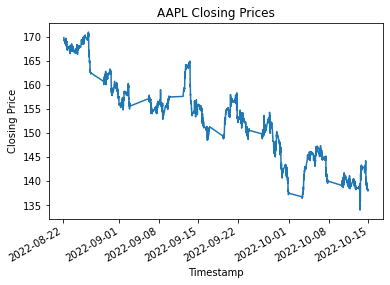

In [13]:
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [14]:
#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns="SIGNAL", inplace=True)

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD
timestamp,,,,,,,,,,,,,,,,,
2022-08-22 05:00:00+00:00,169.65,169.80,169.65,169.80,521,6,169.756526,169.800000,169.800000,169.800000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2022-08-22 06:10:00+00:00,169.22,169.22,169.22,169.22,100,1,169.220000,169.477778,169.495500,169.504200,NaN,NaN,0.000000,NaN,NaN,NaN,-0.013013
2022-08-22 06:55:00+00:00,169.20,169.20,169.20,169.20,299,1,169.200000,169.363934,169.386994,169.398718,NaN,NaN,0.000000,NaN,NaN,NaN,-0.017201
2022-08-22 07:25:00+00:00,169.10,169.10,169.10,169.10,114,6,169.101754,169.274526,169.304143,169.319499,NaN,NaN,0.000000,NaN,NaN,NaN,-0.022295
2022-08-22 08:00:00+00:00,170.29,170.29,169.01,169.08,26457,667,169.262287,169.216659,169.249925,169.267692,NaN,NaN,0.000000,NaN,NaN,NaN,-0.025389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14 23:35:00+00:00,138.05,138.07,138.05,138.07,863,31,138.060834,138.061015,138.117322,138.370395,140.568816,0.038571,38.705731,138.247237,138.1010,137.954763,-0.084623
2022-10-14 23:40:00+00:00,138.08,138.08,138.06,138.08,3472,69,138.075746,138.064812,138.113768,138.359007,140.546116,0.034286,40.136466,138.217757,138.0920,137.966243,-0.077777
2022-10-14 23:45:00+00:00,138.08,138.08,138.05,138.08,3916,88,138.067337,138.067850,138.110552,138.348065,140.523516,0.034286,40.136466,138.184916,138.0835,137.982084,-0.071527


### Add Discrete Features Columns to the DataFrame

In [15]:
# discrete or continuous features (techinal indicators) may be used
continuous_features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_LOWER", "MACD"]
discrete_features = ["Bollinger_Bands_Above_Upper_BB", "Bollinger_Bands_Below_Lower_BB", "9EMA/20EMA_Cross, 9EMA>20EMA", "9EMA/20EMA_Cross, 9EMA<20EMA", "50EMA/200SMA_Cross, 50EMA>200SMA", "50EMA/200SMA_Cross, 50EMA<200SMA", "RSI_Over_70", "RSI_Under_30", "VWAP_Cross_From_Above", "VWAP_Cross_From_Below"]
all_features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_MIDDLE", "BB_LOWER", "MACD", "Bollinger_Bands_Above_Upper_BB", "Bollinger_Bands_Below_Lower_BB", "9EMA/20EMA_Cross, 9EMA>20EMA", "9EMA/20EMA_Cross, 9EMA<20EMA", "50EMA/200SMA_Cross, 50EMA>200SMA", "50EMA/200SMA_Cross, 50EMA<200SMA", "RSI_Over_70", "RSI_Under_30", "VWAP_Cross_From_Above", "VWAP_Cross_From_Below"]

# add discrete_features to the DataFrame
for feature in discrete_features:
    signals_df[feature] = 0.0

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,Bollinger_Bands_Above_Upper_BB,Bollinger_Bands_Below_Lower_BB,"9EMA/20EMA_Cross, 9EMA>20EMA","9EMA/20EMA_Cross, 9EMA<20EMA","50EMA/200SMA_Cross, 50EMA>200SMA","50EMA/200SMA_Cross, 50EMA<200SMA",RSI_Over_70,RSI_Under_30,VWAP_Cross_From_Above,VWAP_Cross_From_Below
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-22 05:00:00+00:00,169.65,169.80,169.65,169.80,521,6,169.756526,169.800000,169.800000,169.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-22 06:10:00+00:00,169.22,169.22,169.22,169.22,100,1,169.220000,169.477778,169.495500,169.504200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-22 06:55:00+00:00,169.20,169.20,169.20,169.20,299,1,169.200000,169.363934,169.386994,169.398718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-22 07:25:00+00:00,169.10,169.10,169.10,169.10,114,6,169.101754,169.274526,169.304143,169.319499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-22 08:00:00+00:00,170.29,170.29,169.01,169.08,26457,667,169.262287,169.216659,169.249925,169.267692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14 23:35:00+00:00,138.05,138.07,138.05,138.07,863,31,138.060834,138.061015,138.117322,138.370395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-14 23:40:00+00:00,138.08,138.08,138.06,138.08,3472,69,138.075746,138.064812,138.113768,138.359007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-14 23:45:00+00:00,138.08,138.08,138.05,138.08,3916,88,138.067337,138.067850,138.110552,138.348065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Encode Discrete Features (EMA Crosses, SMA Crosses, etc...)

In [16]:
# Generate the trading signals 1  for a long position trading algorithm
# where 1 is when the Close price is less than the BB_LOWER window
# where 1 is when the Close price is greater the the BB_UPPER window
for index, row in signals_df.iterrows():
    if row["close"] < row["BB_LOWER"]:
        signals_df.loc[index, "Bollinger_Bands_Below_Lower_BB"] = 1
    if row["close"] > row["BB_UPPER"]:
        signals_df.loc[index,"Bollinger_Bands_Above_Upper_BB"] = 1

# Generate the trading signal 1 or 0
# where 1 is when the Short window is greater than (or crosses over) the Long Window
# where 0 is when the Short window is under the Long window
signals_df["9EMA/20EMA_Cross, 9EMA>20EMA"][9:] = np.where(
    signals_df["9EMA"][9:] > signals_df["20EMA"][9:], 1.0, 0.0)
# Calculate the points in time at which a position should be taken, 1 or 1, when there is ANY cross
# we will get rid of -1s at the end
signals_df["9EMA/20EMA_Cross, 9EMA>20EMA"] = signals_df["9EMA/20EMA_Cross, 9EMA>20EMA"].diff()
signals_df["9EMA/20EMA_Cross, 9EMA<20EMA"] = (signals_df["9EMA/20EMA_Cross, 9EMA>20EMA"]) * -1

# Generate the trading signal 1 or 0
# where 1 is when the Short window is greater than (or crosses over) the Long Window
# where 0 is when the Short window is under the Long window
signals_df["50EMA/200SMA_Cross, 50EMA>200SMA"][50:] = np.where(
    signals_df["50EMA"][50:] > signals_df["200SMA"][50:], 1.0, 0.0)
# Calculate the points in time at which a position should be taken, 1 or 1, when there is ANY cross
# we will get rid of -1s at the end
signals_df["50EMA/200SMA_Cross, 50EMA>200SMA"] = signals_df["50EMA/200SMA_Cross, 50EMA>200SMA"].diff()
signals_df["50EMA/200SMA_Cross, 50EMA<200SMA"] = (signals_df["50EMA/200SMA_Cross, 50EMA>200SMA"]) * -1

# WORK IN PROGRESS - WILL ADD SOON
# # Generate the trading signal 1 or 0,
# # where 1 is when the MACD is Increasing
# # where 0 is when the MACD is Decreasing
# n = signals_df["MACD_Rate"].index
# signals_df["MACD_Rate"] = np.where(
#     signals_df["MACD"][n+1] > signals_df["MACD"][n], 1.0, 0.0)
# # Calculate the points in time at which a position should be taken, 1 or -1
# signals_df["MACD_Rate"] = signals_df["MACD_Rate"].diff()

# Generate the trading signals 1 (entry) for a long position trading algorithm
# where 1 is when the RSI is below 30
# where 1 is when the RSI is above 70
for index, row in signals_df.iterrows():
    if 30 > row["RSI"]:
        signals_df.loc[index, "RSI_Under_30"] = 1
    if 70 < row["RSI"]:
        signals_df.loc[index,"RSI_Over_70"] = 1

# Generate the trading signal 1 or 0,
# where 1 is when the price is above VWAP
# where 0 is when the price is below VWAP
signals_df["VWAP_Cross_From_Above"] = np.where(
    signals_df["vwap"] <= signals_df["close"], 1.0, 0)
# Calculate the points in time at which a position should be taken, 1, when price crosses VWAP
# we will get rid of -1s at the end
signals_df["VWAP_Cross_From_Above"] = signals_df["VWAP_Cross_From_Above"].diff()
signals_df["VWAP_Cross_From_Below"] = (signals_df["VWAP_Cross_From_Above"]) * -1

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Exit Price"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df.head(100)

C:\Users\tjfoo\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tjfoo\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,"9EMA/20EMA_Cross, 9EMA>20EMA","9EMA/20EMA_Cross, 9EMA<20EMA","50EMA/200SMA_Cross, 50EMA>200SMA","50EMA/200SMA_Cross, 50EMA<200SMA",RSI_Over_70,RSI_Under_30,VWAP_Cross_From_Above,VWAP_Cross_From_Below,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-22 05:00:00+00:00,169.6500,169.80,169.6500,169.800,521,6,169.756526,169.800000,169.800000,169.800000,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,0
2022-08-22 06:10:00+00:00,169.2200,169.22,169.2200,169.220,100,1,169.220000,169.477778,169.495500,169.504200,...,0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,0,0
2022-08-22 06:55:00+00:00,169.2000,169.20,169.2000,169.200,299,1,169.200000,169.363934,169.386994,169.398718,...,0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,0,0
2022-08-22 07:25:00+00:00,169.1000,169.10,169.1000,169.100,114,6,169.101754,169.274526,169.304143,169.319499,...,0.0,-0.0,0.0,-0.0,0.0,1.0,-1.0,1.0,0,0
2022-08-22 08:00:00+00:00,170.2900,170.29,169.0100,169.080,26457,667,169.262287,169.216659,169.249925,169.267692,...,0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-22 15:35:00+00:00,168.5800,168.66,168.4900,168.560,446424,5116,168.563476,168.506810,168.579897,168.724790,...,0.0,-0.0,0.0,-0.0,0.0,0.0,-1.0,1.0,0,0
2022-08-22 15:40:00+00:00,168.5650,168.80,168.5300,168.560,631781,6255,168.693772,168.517448,168.578002,168.718191,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0,0
2022-08-22 15:45:00+00:00,168.5651,168.69,168.4800,168.556,464864,5182,168.569971,168.525158,168.575907,168.711702,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0,0


### Create Volatility Based Targets and Stops

In [17]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 3
risk = 1

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df["Exit Price"].iloc[j] = stop
            signals_df["Exit"].iloc[j] = -1
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df["Exit Price"].iloc[j] = target
            signals_df["Exit"].iloc[j] = 1
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

C:\Users\tjfoo\anaconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,"9EMA/20EMA_Cross, 9EMA>20EMA","9EMA/20EMA_Cross, 9EMA<20EMA","50EMA/200SMA_Cross, 50EMA>200SMA","50EMA/200SMA_Cross, 50EMA<200SMA",RSI_Over_70,RSI_Under_30,VWAP_Cross_From_Above,VWAP_Cross_From_Below,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-23 06:10:00+00:00,166.80,166.80,166.80,166.80,554,8,166.800289,167.310304,167.530791,167.691809,...,0.0,-0.0,0.0,-0.0,0.0,1.0,-1.0,1.0,166.660721,-1
2022-08-23 07:00:00+00:00,166.47,166.47,166.47,166.47,176,1,166.470000,167.142243,167.429763,167.643880,...,0.0,-0.0,0.0,-0.0,0.0,1.0,1.0,-1.0,166.943550,1
2022-08-23 07:10:00+00:00,166.81,166.81,166.81,166.81,130,1,166.810000,167.075794,167.370738,167.611169,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,167.345693,1
2022-08-23 08:00:00+00:00,167.35,167.95,167.35,167.92,9782,236,167.784971,167.244636,167.423049,167.623284,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,167.663579,-1
2022-08-23 08:05:00+00:00,167.99,168.20,167.99,168.08,8818,212,168.097839,167.411708,167.485615,167.641199,...,0.0,-0.0,0.0,-0.0,0.0,0.0,-1.0,1.0,167.806436,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14 23:35:00+00:00,138.05,138.07,138.05,138.07,863,31,138.060834,138.061015,138.117322,138.370395,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.000000,0
2022-10-14 23:40:00+00:00,138.08,138.08,138.06,138.08,3472,69,138.075746,138.064812,138.113768,138.359007,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.000000,0
2022-10-14 23:45:00+00:00,138.08,138.08,138.05,138.08,3916,88,138.067337,138.067850,138.110552,138.348065,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.000000,0


### Data Cleaning

In [18]:
# check if there is potentially-unwanted zeros in the dataframe
# zeros come from the end of the dataframe where neither the target or stop were hit
signals_df["Exit"].value_counts()

-1    5313
 1    1965
 0      14
Name: Exit, dtype: int64

In [19]:
# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]
signals_df["Exit"].value_counts()

-1    5313
 1    1965
Name: Exit, dtype: int64

In [20]:
# check for unwanted -0s and -1s
for i in discrete_features:
    print(signals_df[i].value_counts())

0.0    6861
1.0     417
Name: Bollinger_Bands_Above_Upper_BB, dtype: int64
0.0    6880
1.0     398
Name: Bollinger_Bands_Below_Lower_BB, dtype: int64
 0.0    6952
 1.0     163
-1.0     163
Name: 9EMA/20EMA_Cross, 9EMA>20EMA, dtype: int64
-0.0    6952
-1.0     163
 1.0     163
Name: 9EMA/20EMA_Cross, 9EMA<20EMA, dtype: int64
 0.0    7226
 1.0      26
-1.0      26
Name: 50EMA/200SMA_Cross, 50EMA>200SMA, dtype: int64
-0.0    7226
-1.0      26
 1.0      26
Name: 50EMA/200SMA_Cross, 50EMA<200SMA, dtype: int64
0.0    6930
1.0     348
Name: RSI_Over_70, dtype: int64
0.0    6802
1.0     476
Name: RSI_Under_30, dtype: int64
 0.0    3708
-1.0    1785
 1.0    1785
Name: VWAP_Cross_From_Above, dtype: int64
-0.0    3708
 1.0    1785
-1.0    1785
Name: VWAP_Cross_From_Below, dtype: int64


In [21]:
# remove all unwanted -0s and -1s which will affect ML model
for i in discrete_features:
    signals_df[i] = signals_df[i].replace(-0, 0)
    signals_df[i] = signals_df[i].replace(-1, 0)
    print(signals_df[i].value_counts())

0.0    6861
1.0     417
Name: Bollinger_Bands_Above_Upper_BB, dtype: int64
0.0    6880
1.0     398
Name: Bollinger_Bands_Below_Lower_BB, dtype: int64
0.0    7115
1.0     163
Name: 9EMA/20EMA_Cross, 9EMA>20EMA, dtype: int64
0.0    7115
1.0     163
Name: 9EMA/20EMA_Cross, 9EMA<20EMA, dtype: int64
0.0    7252
1.0      26
Name: 50EMA/200SMA_Cross, 50EMA>200SMA, dtype: int64
0.0    7252
1.0      26
Name: 50EMA/200SMA_Cross, 50EMA<200SMA, dtype: int64
0.0    6930
1.0     348
Name: RSI_Over_70, dtype: int64
0.0    6802
1.0     476
Name: RSI_Under_30, dtype: int64
0.0    5493
1.0    1785
Name: VWAP_Cross_From_Above, dtype: int64
0.0    5493
1.0    1785
Name: VWAP_Cross_From_Below, dtype: int64


C:\Users\tjfoo\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tjfoo\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Setup Train and Test Sets for Discrete and Continuous Features

In [22]:
# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=1))

training_begin, training_end

('2022-08-23 06:10:00+00:00', '2022-09-23 06:10:00+00:00')

In [23]:
# choose if you want continuous or discrete features
discrete_X = signals_df[discrete_features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
discrete_y = signals_df["Exit"]
discrete_X.head()

,Bollinger_Bands_Above_Upper_BB,Bollinger_Bands_Below_Lower_BB,"9EMA/20EMA_Cross, 9EMA>20EMA","9EMA/20EMA_Cross, 9EMA<20EMA","50EMA/200SMA_Cross, 50EMA>200SMA","50EMA/200SMA_Cross, 50EMA<200SMA",RSI_Over_70,RSI_Under_30,VWAP_Cross_From_Above,VWAP_Cross_From_Below
timestamp,,,,,,,,,,
2022-08-23 06:10:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2022-08-23 07:00:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2022-08-23 07:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-23 08:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-23 08:05:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Split the data into training and testing sets.

In [24]:
# Splitting into Train and Test sets
discrete_X_train = discrete_X.loc[training_begin: training_end]
discrete_y_train = discrete_y.loc[training_begin: training_end]

# Generate the discrete X_test and y_test DataFrames
discrete_X_test = discrete_X.loc[training_end:]
discrete_y_test = discrete_y.loc[training_end:]

# code above is used in liue of 
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [25]:
# we must balance out dataset
discrete_rus = RandomUnderSampler(random_state=1)
undersampled_discrete_X_train, undersampled_discrete_y_train = discrete_rus.fit_resample(discrete_X_train, discrete_y_train)

In [26]:
# choose if you want continuous or discrete features
continuous_X = signals_df[continuous_features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
continuous_y = signals_df["Exit"]
continuous_y.head()

timestamp
2022-08-23 06:10:00+00:00   -1
2022-08-23 07:00:00+00:00    1
2022-08-23 07:10:00+00:00    1
2022-08-23 08:00:00+00:00   -1
2022-08-23 08:05:00+00:00   -1
Name: Exit, dtype: int64

In [27]:
# Splitting into Train and Test sets
continuous_X_train = continuous_X.loc[training_begin: training_end]
continuous_y_train = continuous_y.loc[training_begin: training_end]

# Generate the continuous X_test and y_test DataFrames
continuous_X_test = continuous_X.loc[training_end:]
continuous_y_test = continuous_y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [28]:
# Scale the continuous data
scaler = StandardScaler()
X_scaler = scaler.fit(continuous_X_train)
continuous_X_train_scaled = X_scaler.transform(continuous_X_train)
continuous_X_test_scaled = X_scaler.transform(continuous_X_test)

In [29]:
# Undersample the continuous data
continuous_rus = RandomUnderSampler(random_state=1)
undersampled_continuous_X_train_scaled, undersampled_continuous_y_train = continuous_rus.fit_resample(continuous_X_train_scaled, continuous_y_train)

### Support Vector Machine (SVC) Model

In [30]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using undersampled_continuous_X_train_scaled and undersampled_continuous_y_train
svm_model = svm_model.fit(undersampled_continuous_X_train_scaled, undersampled_continuous_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(undersampled_continuous_X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1,  1, -1, -1, -1, -1,  1, -1, -1, -1], dtype=int64)

In [31]:
# Evaluate the model using a classification report
svm_training_report = classification_report(undersampled_continuous_y_train, training_signal_predictions)
print(svm_training_report)

              precision    recall  f1-score   support

          -1       0.67      0.51      0.58      1159
           1       0.61      0.75      0.67      1159

    accuracy                           0.63      2318
   macro avg       0.64      0.63      0.63      2318
weighted avg       0.64      0.63      0.63      2318



In [32]:
# Use the trained model to predict the trading signals for the testing data.
svm_testing_signal_predictions = svm_model.predict(continuous_X_test_scaled)

In [33]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(continuous_y_test, svm_testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

          -1       0.72      0.55      0.62      2251
           1       0.24      0.39      0.30       806

    accuracy                           0.51      3057
   macro avg       0.48      0.47      0.46      3057
weighted avg       0.59      0.51      0.54      3057



In [34]:
# Create a predictions DataFrame for SVM
svm_predictions_df = pd.DataFrame(index=continuous_X_test.index)

svm_predictions_df["predicted_signal"] = svm_testing_signal_predictions

svm_predictions_df["actual_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]


svm_predictions_df["trading_algorithm_returns"] = (
    svm_predictions_df["actual_returns"] * svm_predictions_df["predicted_signal"]
)

# Review the DataFrame
svm_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
timestamp,,,
2022-09-23 06:45:00+00:00,1,-0.001188,-0.001188
2022-09-23 07:00:00+00:00,1,0.003524,0.003524
2022-09-23 08:00:00+00:00,1,-0.001313,-0.001313
2022-09-23 08:05:00+00:00,1,-0.001470,-0.001470
2022-09-23 08:10:00+00:00,1,-0.001495,-0.001495


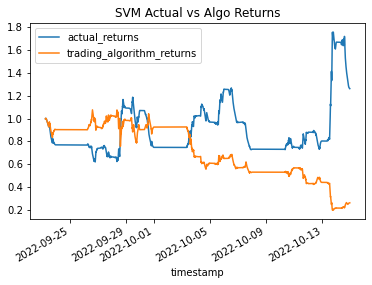

In [35]:
 # Calculated and plotted the cumulative returns for the `actual_returns` and the `trading_algorithm_returns` for the SVM Model
(1 + svm_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title='SVM Actual vs Algo Returns')
plt.savefig(f'{ticker}_svm_vs_act_returns', facecolor='white', edgecolor='white', transparent='false', bbox_inches='tight')

### Stochastic Gradient Descent (SGD) Model

In [37]:
#Create the classifier model
SGD_model = SGDClassifier(random_state=0)
# Fit the model to the data using undersampled_continuous_X_train_scaled and undersampled_continuous_y_train
SGD_model.fit(undersampled_continuous_X_train_scaled, undersampled_continuous_y_train)

# Use the trained model to predict the trading signals for the training data
SGD_training_predictions = SGD_model.predict(undersampled_continuous_X_train_scaled)

# Display the sample predictions
SGD_training_predictions[:5]

array([-1, -1, -1, -1, -1], dtype=int64)

In [38]:
# Evaluate the model using a classification report
SGD_training_report = classification_report(undersampled_continuous_y_train, SGD_training_predictions)
print(SGD_training_report)

              precision    recall  f1-score   support

          -1       0.56      0.53      0.55      1159
           1       0.56      0.58      0.57      1159

    accuracy                           0.56      2318
   macro avg       0.56      0.56      0.56      2318
weighted avg       0.56      0.56      0.56      2318



In [39]:
# Use the trained model to predict the trading signals for the testing data.
SGD_testing_signal_predictions = SGD_model.predict(continuous_X_test_scaled)

In [40]:
# Evaluate the model's ability to predict the trading signal for the testing data
SGD_testing_report = classification_report(continuous_y_test, SGD_testing_signal_predictions)
print(SGD_testing_report)

              precision    recall  f1-score   support

          -1       0.77      0.09      0.16      2251
           1       0.27      0.93      0.41       806

    accuracy                           0.31      3057
   macro avg       0.52      0.51      0.29      3057
weighted avg       0.64      0.31      0.23      3057



In [41]:
# Create a predictions DataFrame for sgd
sgd_predictions_df = pd.DataFrame(index=continuous_X_test.index)

sgd_predictions_df["predicted_signal"] = SGD_testing_signal_predictions

sgd_predictions_df["actual_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]


sgd_predictions_df["trading_algorithm_returns"] = (
    sgd_predictions_df["actual_returns"] * sgd_predictions_df["predicted_signal"]
)

# Review the DataFrame
sgd_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
timestamp,,,
2022-09-23 06:45:00+00:00,1,-0.001188,-0.001188
2022-09-23 07:00:00+00:00,1,0.003524,0.003524
2022-09-23 08:00:00+00:00,1,-0.001313,-0.001313
2022-09-23 08:05:00+00:00,1,-0.001470,-0.001470
2022-09-23 08:10:00+00:00,1,-0.001495,-0.001495


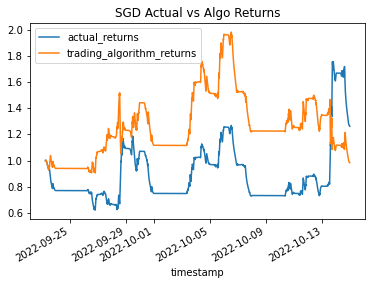

In [42]:
 # Calculated and plotted the cumulative returns for the `actual_returns` and the `trading_algorithm_returns` for the sgd Model
(1 + sgd_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title='SGD Actual vs Algo Returns')
plt.savefig(f'{ticker}_sgd_vs_act_returns', facecolor='white', edgecolor='white', transparent='false', bbox_inches='tight')

###  Decision Tree Model

In [43]:
# Create the decision tree classifier instance
rf_model = tree.DecisionTreeClassifier(random_state=1)

In [44]:
# Fit the model
rf_model = rf_model.fit(undersampled_discrete_X_train, undersampled_discrete_y_train)

In [45]:
# Making predictions using the testing data
predictions = rf_model.predict(discrete_X_test)

# Use the trained model to predict the trading signals for the training data
rf_training_signal_predictions = rf_model.predict(undersampled_discrete_X_train)

In [46]:
# Evaluate the model using a classification report
rf_training_report = classification_report(undersampled_discrete_y_train, rf_training_signal_predictions)
print(rf_training_report)

              precision    recall  f1-score   support

          -1       0.56      0.39      0.46      1159
           1       0.53      0.69      0.60      1159

    accuracy                           0.54      2318
   macro avg       0.54      0.54      0.53      2318
weighted avg       0.54      0.54      0.53      2318



In [47]:
# Use the trained model to predict the trading signals for the testing data.
rf_testing_signal_predictions = rf_model.predict(discrete_X_test)

In [48]:
# Evaluate the model's ability to predict the trading signal for the testing data
rf_testing_report = classification_report(discrete_y_test, rf_testing_signal_predictions)
print(rf_testing_report)

              precision    recall  f1-score   support

          -1       0.75      0.34      0.47      2251
           1       0.27      0.67      0.38       806

    accuracy                           0.43      3057
   macro avg       0.51      0.51      0.43      3057
weighted avg       0.62      0.43      0.45      3057



In [49]:
# Create a predictions DataFrame for rf
rf_predictions_df = pd.DataFrame(index=continuous_X_test.index)

rf_predictions_df["predicted_signal"] = rf_testing_signal_predictions

rf_predictions_df["actual_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]


rf_predictions_df["trading_algorithm_returns"] = (
    rf_predictions_df["actual_returns"] * rf_predictions_df["predicted_signal"]
)

# Review the DataFrame
rf_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
timestamp,,,
2022-09-23 06:45:00+00:00,1,-0.001188,-0.001188
2022-09-23 07:00:00+00:00,1,0.003524,0.003524
2022-09-23 08:00:00+00:00,1,-0.001313,-0.001313
2022-09-23 08:05:00+00:00,1,-0.001470,-0.001470
2022-09-23 08:10:00+00:00,1,-0.001495,-0.001495


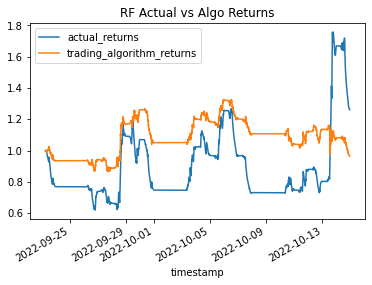

In [50]:
 # Calculated and plotted the cumulative returns for the `actual_returns` and the `trading_algorithm_returns` for the rf Model
(1 + rf_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title='RF Actual vs Algo Returns')
plt.savefig(f'{ticker}_rf_vs_act_returns', facecolor='white', edgecolor='white', transparent='false', bbox_inches='tight')

In [51]:
# markdown here about exporting the graph

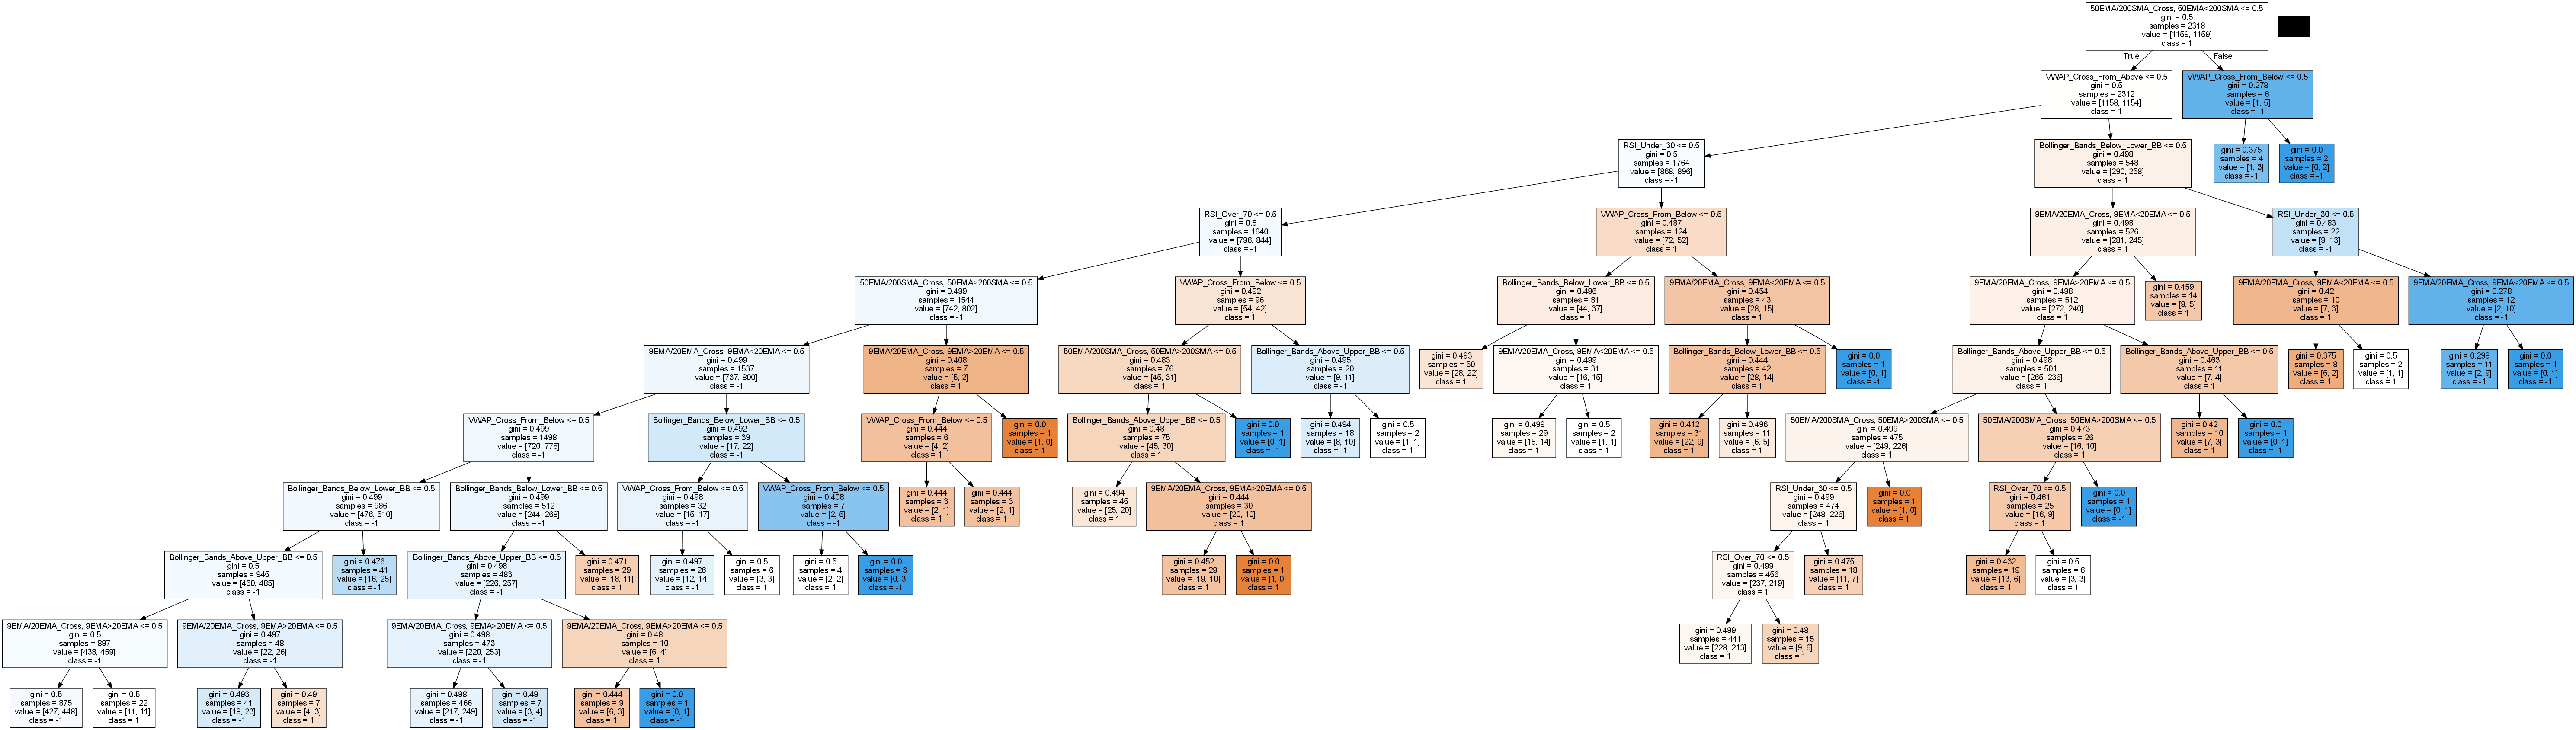

In [52]:
# Create DOT data
dot_data = tree.export_graphviz(
    rf_model, out_file=None, feature_names=discrete_X.columns, class_names=["1", "-1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())



In [53]:
# When saving the image, Path() is not used because graph.write_<file_type>() must take a string object
# Saving the tree as PDF
file_path = "transactions_tree.pdf"
graph.write_pdf(file_path)

# Saving the tree as PNG
file_path = "transactions_tree.png"
graph.write_png(file_path)


True

In [54]:
# rank the most important features
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, discrete_X.columns), reverse=True)
importances_sorted[:10]

[(0.2298667052402657, 'RSI_Under_30'),
 (0.14948405943381016, 'Bollinger_Bands_Below_Lower_BB'),
 (0.1139894631399975, '50EMA/200SMA_Cross, 50EMA>200SMA'),
 (0.09882516171918944, 'VWAP_Cross_From_Below'),
 (0.0919595191572239, 'Bollinger_Bands_Above_Upper_BB'),
 (0.07219027706155393, 'RSI_Over_70'),
 (0.07138969231454599, '9EMA/20EMA_Cross, 9EMA>20EMA'),
 (0.06795526425916155, '9EMA/20EMA_Cross, 9EMA<20EMA'),
 (0.05601950662542566, '50EMA/200SMA_Cross, 50EMA<200SMA'),
 (0.04832035104882627, 'VWAP_Cross_From_Above')]

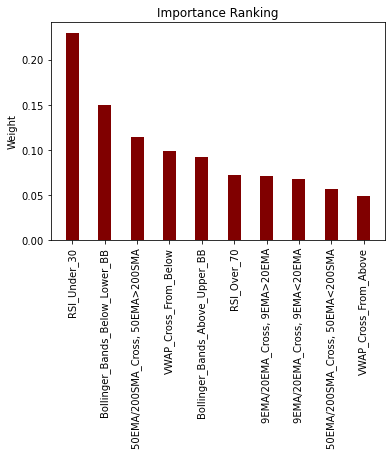

In [55]:
#Create Two Lists to make a bar graph outlining the weight of each discrete feature
i = 0
x = []
y = []

for k in importances_sorted:
    x.append(str(importances_sorted[i][1]))
    y.append(importances_sorted[i][0])
    i += 1

#Create and save the bar graph
plt.bar(x, y, color ='maroon', width = 0.4)
plt.title('Importance Ranking')
plt.ylabel('Weight')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.savefig(f'{ticker}_importance_ranking', facecolor='white', edgecolor='white', transparent='false', bbox_inches='tight')